## 야후 파이낸스와 네이버 금융비교

[*********************100%***********************]  1 of 1 completed


C:\Users\82102\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


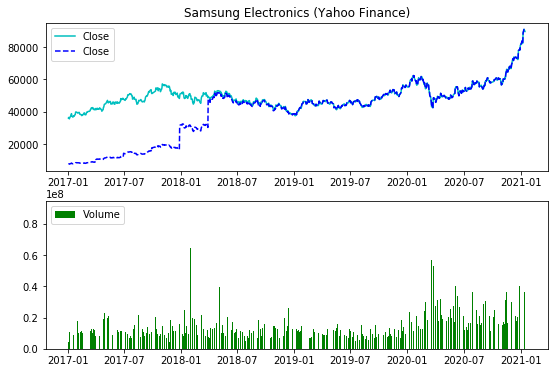

In [2]:
from pandas_datareader import  data as  pdr
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt

df = pdr.get_data_yahoo('005930.KS','2017-01-01')#삼성전자 데이터 2017-01-01부터조회

#그래프 그려보자
#문제가 뭔지
plt.figure(figsize =(9,6))
plt.subplot(2,1,1) #2행1열에 그리자
plt.title('Samsung Electronics (Yahoo Finance)')
plt.plot(df.index, df['Close'], 'c', label='Close') #삼성전자 종가를 청록색 실선으로 표시
plt.plot(df.index, df['Adj Close'], 'b--', label='Close')#삼성전자 수정종가 그리자
plt.legend(loc = 'best')
plt.subplot(2,1,2)
plt.bar(df.index, df['Volume'], color = 'g', label = 'Volume')
plt.legend(loc ='best')
plt.show()

In [3]:
!pip install pymysql

In [21]:
import pymysql
#디비 연결해서 버전확인
connection = pymysql.connect(host = '127.0.0.1', port = 3307, db ='INVESTAR',
                            user = 'root', passwd='dhqud4892', autocommit = True)
                            #autoucommit이 true면 별도로 commit()함수를 호출하지 않아도 된다

cursor = connection.cursor() #cursor() 함수를 사용해 cursor 객체를 생성한다
cursor.execute("SELECT version();")
result = cursor.fetchone()
#튜플로 리턴된다
print("MariaDB version : {}".format(result))


connection.close()

MariaDB version : ('10.5.8-MariaDB',)


# 주식시세 매일 디비로 업뎃

In [11]:
#뷰티플 수프와 판다스로 읽어서 마리아 디비에 자동 업뎃하는 모듈 생성
#스텁코드 작성
class DBUpdater:
    def __init__(self):
        '''생성자: mariadb 연결 및 종목코드 딕셔너리 생성'''
    def __del__(self):
        '''소멸자: mariadb 연결해제'''
    def read_krx_code(self):
        '''KRX로부터 상장법인목록 파일을 읽어와서 데이터 프레임으로 반환'''
    def update_comp_info(self):
        '''종목코드를 company_info 테이블에 업데이트 한 후 딕셔너리에 저장'''
    def read_naver(self, code, company, pages_to_fetch):
        '''네이버 금융에서 주식시세를 읽어서 데이터프레임으로 반환'''
    def replace_into_db(self, df, num, code, company):
        '''네이버 금융에서 읽어온 주식시세를 디비에 리플레이스'''
    def update_daily_price(self, pages_to_fetch):
        '''KRX 상장법인의 주식 시세를 네이버로부터 읽어서 디비에 업데이트'''
    def execute_daily(self):
        '''실행 즉시 및 매일 오후 다섯시에 daily_price 테이블 업데이트'''
        
if __name__ =='__main__':
    dbu = DBUpdater()
    dbu.execute_daily()
    

In [4]:
#먼저 마리아디비 접속과 해체를 설정하자
import pymysql
import pandas as pd
from datetime import datetime

class DBUpdater:
    def __init__(self):
        '''생성자: mariadb 연결 및 종목코드 딕셔너리 생성'''
        self.conn = pymysql.connect(host ='127.0.0.1',port = 3307, user = 'root', password = 'dhqud4892', 
                                    db='INVESTAR', charset = 'utf8') #인코딩형식 미리미리 지정하자 이거 때문에 오류 잘나 
        
        with self.conn.cursor() as curs:
            sql = """
            CREATE TABLE IF NOT EXISTS company_info(
                CODE	VARCHAR(20),
                company	VARCHAR(40),
                last_update	DATE,
                PRIMARY KEY(CODE)
                )
            """
            curs.execute(sql)
            sql = """
            CREATE TABLE IF NOT EXISTS dialy_price(
                code	VARCHAR(20),
                date	DATE,
                open	BIGINT(20),
                high	BIGINT(20),
                low		BIGINT(20),
                close	BIGINT(20),
                diff	BIGINT(20),
                volume	BIGINT(20),
                PRIMARY KEY (code, date)
                )
            """
            curs.execute(sql)
        self.conn.commit()
        
        self.codes = dict()
        self.update_comp_info() #주식코드를 company_info로 업뎃하기위함
        
    def __del__(self):
        '''소멸자: mariadb 연결해제'''
        self.conn.close()
    def read_krx_code(self):
        '''KRX로부터 상장법인목록 파일을 읽어와서 데이터 프레임으로 반환'''
        url = 'https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13'#주의
        krx = pd.read_html(url, header = 0)[0] #상장 법인 파일 읽자
        krx = krx[['종목코드','회사명']]#요거 두개만 가져오자
        krx = krx.rename(columns ={'종목코드': 'code', '회사명':'company'})
        krx.code = krx.code.map('{:06d}'.format)#6자리로 맞춰주는것
        
    def update_comp_info(self):
        '''종목코드를 company_info 테이블에 업데이트 한 후 딕셔너리에 저장'''
        sql = "SELECT * FROM company_info"
        df = pd.read_sql(sql, self.conn) #컴퍼니 인포테이블을 읽자
        for idx in range(len(df)):
            self.codes[df['code'].values[idx]]=df['company'].values[idx]
            #위서 읽은 데이터 프레임을 이용해서 코드와 회사로 딕셔너리를 만들자
            with self.conn.cursor()as curs:
                sql = "SELECT max(last_update) FROM company_info"
                curs.execute(sql)
                rs = curs.fetchone() #select max 구문으로 디비에서 가장 최근 업데이트를 가져온다
                today = datetime.today().strftime('%Y-%m-%d')
                
                if rs[0] == None or rs[0].strftime('%Y-%m-%d') < today:
                #위서 구한 날짜가 없거나 오래된 경우만 업뎃
                    krx = self.read_krx_code()#krx 상장기업 목록 파일 읽어서 데이터프레임에저장
                    for idx in range(len(krx)):
                        code = krx.code.values[idx]
                        company = krx.company.values[idx]
                        sql = f"REPLACE INTO company_info (code, company, last_update) VALUES ('{code}', '{company}', '{today}')"
                        curs.execute(sql)#replace into문으로 종목코드,회사,날짜를 디비에 저장
                        self.codes[code] = company #코드 딕셔너리에 회사명을 추가한다
                        tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                        print(f"[{tmnow}] #{idx+1:04d} REPLACE INTO company_info"\
                             f"VALUES ({code}, {company},{today})")
                    self.conn.comit()
                    print('')
#     def read_naver(self, code, company, pages_to_fetch):
#         '''네이버 금융에서 주식시세를 읽어서 데이터프레임으로 반환'''
#     def replace_into_db(self, df, num, code, company):
#         '''네이버 금융에서 읽어온 주식시세를 디비에 리플레이스'''
#     def update_daily_price(self, pages_to_fetch):
#         '''KRX 상장법인의 주식 시세를 네이버로부터 읽어서 디비에 업데이트'''
#     def execute_daily(self):
#         '''실행 즉시 및 매일 오후 다섯시에 daily_price 테이블 업데이트'''
        
if __name__ =='__main__':
    dbu = DBUpdater()
    dbu.update_comp_info()
    #dbu.execute_daily()

KeyError: 'code'

In [23]:
#파일크기 때무에 분할해서 코드 치고 한번에 하자
import pandas as pd
from datetime import datetime

class DBUpdater:
    def update_comp_info(self):
        '''종목코드를 company_info 테이블에 업데이트 한 후 딕셔너리에 저장'''
        sql = "SELECT * FROM company_info"
        df = pd.read_sql(sql, self.conn) #컴퍼니 인포테이블을 읽자
        for idx in range(len(df)):
            self.codes[df['code'].values[idx]]=df['company'].values[idx]
            #위서 읽은 데이터 프레임을 이용해서 코드와 회사로 딕셔너리를 만들자
            with self.conn.cursor()as curs:
                sql = "SELECT max(last_update) FROM company_info"
                curs.execute(sql)
                rs = curs.fetchone() #select max 구문으로 디비에서 가장 최근 업데이트를 가져온다
                today = datetime.today().strftime('%Y-%m-%d')
                
                if rs[0] == None or rs[0].strftime('%Y-%m-%d') < today:
                #위서 구한 날짜가 없거나 오래된 경우만 업뎃
                    krx = self.read_krx_code()#krx 상장기업 목록 파일 읽어서 데이터프레임에저장
                    for idx in range(len(krx)):
                        code = krx.code.values[idx]
                        company = krx.company.values[idx]
                        sql = f"REPLACE INTO company_info (code, company, last_update) VALUES ('{code}', '{company}', '{today}')"
                        curs.execute(sql)#replace into문으로 종목코드,회사,날짜를 디비에 저장
                        self.codes[code] = company #코드 딕셔너리에 회사명을 추가한다
                        tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                        print(f"[{tmnow}] {idx:04d} REPLACE INTO company_info"\
                             f"VALUES ({code}, {company},{today})")
                    self.conn.comit()
                    print('')

SyntaxError: EOL while scanning string literal (<ipython-input-23-a472566f6044>, line 32)

In [30]:
        with self.conn.cursor() as curs:
            sql = "SELECT max(last_update) FROM company_info"
            curs.execute(sql)
            rs = curs.fetchone()
            today = datetime.today().strftime('%Y-%m-%d')
            if rs[0] == None or rs[0].strftime('%Y-%m-%d') < today:
                krx = self.read_krx_code()
                for idx in range(len(krx)):
                    code = krx.code.values[idx]
                    company = krx.company.values[idx]                
                    sql = f"REPLACE INTO company_info (code, company, last"\
                        f"_update) VALUES ('{code}', '{company}', '{today}')"
                    curs.execute(sql)
                    self.codes[code] = company
                    tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                    print(f"[{tmnow}] #{idx+1:04d} REPLACE INTO company_info "\
                        f"VALUES ({code}, {company}, {today})")
                self.conn.commit()

  Could not find a version that satisfies the requirement a_module (from versions: )
No matching distribution found for a_module


In [34]:

import os
path = os.path.abspath(DBUpdater.__file__)

AttributeError: type object 'DBUpdater' has no attribute '__file__'

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import pymysql, calendar, time, json
import requests
from datetime import datetime
from threading import Timer

class DBUpdater:  
    def __init__(self):
        """생성자: MariaDB 연결 및 종목코드 딕셔너리 생성"""
        self.conn = pymysql.connect(host ='127.0.0.1',port = 3307, user = 'root', 
                                    password = 'dhqud4892', db='INVE', charset='utf8')
        
        with self.conn.cursor() as curs:
            sql = """
            CREATE TABLE IF NOT EXISTS company_info (
                code VARCHAR(20),
                company VARCHAR(40),
                last_update DATE,
                PRIMARY KEY (code))
            """
            curs.execute(sql)
            sql = """
            CREATE TABLE IF NOT EXISTS daily_price (
                code VARCHAR(20),
                date DATE,
                open BIGINT(20),
                high BIGINT(20),
                low BIGINT(20),
                close BIGINT(20),
                diff BIGINT(20),
                volume BIGINT(20),
                PRIMARY KEY (code, date))
            """
            curs.execute(sql)
        self.conn.commit()
        
        self.codes = dict()
        self.update_comp_info
               
    def __del__(self):
        """소멸자: MariaDB 연결 해제"""
        self.conn.close() 
    
    def read_krx_code(self):
        """KRX로부터 상장기업 목록 파일을 읽어와서 데이터프레임으로 반환"""
        url = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method='\
            'download&searchType=13'
        krx = pd.read_html(url, header=0)[0]
        krx = krx[['종목코드', '회사명']]
        krx = krx.rename(columns={'종목코드': 'code', '회사명': 'company'})
        krx.code = krx.code.map('{:06d}'.format)
        return krx

    
    def update_comp_info(self):
        """종목코드를 company_info 테이블에 업데이트 한 후 딕셔너리에 저장"""
        sql = "SELECT * FROM company_info"
        df = pd.read_sql(sql, self.conn)
        for idx in range(len(df)):
            self.codes[df['code'].values[idx]] = df['company'].values[idx]
                    
        with self.conn.cursor() as curs:
            sql = "SELECT max(last_update) FROM company_info"
            curs.execute(sql)
            rs = curs.fetchone()
            today = datetime.today().strftime('%Y-%m-%d')
            
            if rs[0] == None or rs[0].strftime('%Y-%m-%d') < today:
                krx = self.read_krx_code()
                for idx in range(len(krx)):
                    code = krx.code.values[idx]
                    company = krx.company.values[idx]                
                    sql = f"REPLACE INTO company_info (code, company, last"\
                        f"_update) VALUES ('{code}', '{company}', '{today}')"
                    curs.execute(sql)
                    self.codes[code] = company
                    tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                    print(f"[{tmnow}] #{idx+1:04d} REPLACE INTO company_info "\
                        f"VALUES ({code}, {company}, {today})")
                self.conn.commit()
                print('')              

    def read_naver(self, code, company, pages_to_fetch):
        """네이버에서 주식 시세를 읽어서 데이터프레임으로 반환"""
        try:
            url = f"http://finance.naver.com/item/sise_day.nhn?code={code}"
            html = BeautifulSoup(requests.get(url,
                headers={'User-agent': 'Mozilla/5.0'}).text, "lxml")
            pgrr = html.find("td", class_="pgRR")
            if pgrr is None:
                return None
            s = str(pgrr.a["href"]).split('=')
            lastpage = s[-1] 
            df = pd.DataFrame()
            pages = min(int(lastpage), pages_to_fetch)
            for page in range(1, pages + 1):
                pg_url = '{}&page={}'.format(url, page)
                df = df.append(pd.read_html(requests.get(pg_url,
                    headers={'User-agent': 'Mozilla/5.0'}).text)[0])                                          
                tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                print('[{}] {} ({}) : {:04d}/{:04d} pages are downloading...'.
                    format(tmnow, company, code, page, pages), end="\r")
            df = df.rename(columns={'날짜':'date','종가':'close','전일비':'diff'
                ,'시가':'open','고가':'high','저가':'low','거래량':'volume'})
            df['date'] = df['date'].replace('.', '-')
            df = df.dropna()
            df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close',
                'diff', 'open', 'high', 'low', 'volume']].astype(int)
            df = df[['date', 'open', 'high', 'low', 'close', 'diff', 'volume']]
        except Exception as e:
            print('Exception occured :', str(e))
            return None
        return df

    def replace_into_db(self, df, num, code, company):
        """네이버에서 읽어온 주식 시세를 DB에 REPLACE"""
        with self.conn.cursor() as curs:
            for r in df.itertuples():
                sql = f"REPLACE INTO daily_price VALUES ('{code}', "\
                    f"'{r.date}', {r.open}, {r.high}, {r.low}, {r.close}, "\
                    f"{r.diff}, {r.volume})"
                curs.execute(sql)
            self.conn.commit()
            print('[{}] #{:04d} {} ({}) : {} rows > REPLACE INTO daily_'\
                'price [OK]'.format(datetime.now().strftime('%Y-%m-%d'\
                ' %H:%M'), num+1, company, code, len(df)))

    def update_daily_price(self, pages_to_fetch):
        """KRX 상장법인의 주식 시세를 네이버로부터 읽어서 DB에 업데이트"""  
        for idx, code in enumerate(self.codes):
            df = self.read_naver(code, self.codes[code], pages_to_fetch)
            if df is None:
                continue
            self.replace_into_db(df, idx, code, self.codes[code])            

    def execute_daily(self):
        """실행 즉시 및 매일 오후 다섯시에 daily_price 테이블 업데이트"""
        self.update_comp_info()
        
        try:
            with open('config.json', 'r') as in_file:
                config = json.load(in_file)
                pages_to_fetch = config['pages_to_fetch']
        except FileNotFoundError:
            with open('config.json', 'w') as out_file:
                pages_to_fetch = 30 
                config = {'pages_to_fetch': 30}
                json.dump(config, out_file)
        self.update_daily_price(pages_to_fetch)

        tmnow = datetime.now()
        lastday = calendar.monthrange(tmnow.year, tmnow.month)[1]
        if tmnow.month == 12 and tmnow.day == lastday:
            tmnext = tmnow.replace(year=tmnow.year+1, month=1, day=1,
                hour=17, minute=0, second=0)
        elif tmnow.day == lastday:
            tmnext = tmnow.replace(month=tmnow.month+1, day=1, hour=17,
                minute=0, second=0)
        else:
            tmnext = tmnow.replace(day=tmnow.day+1, hour=17, minute=0,
                second=0)   
        tmdiff = tmnext - tmnow
        secs = tmdiff.seconds
        t = Timer(secs, self.execute_daily)
        print("Waiting for next update ({}) ... ".format(tmnext.strftime
            ('%Y-%m-%d %H:%M')))
        t.start()

if __name__ == '__main__':
    dbu = DBUpdater()
#     dbu.update_comp_info()
    dbu.execute_daily()

[2021-01-17 22:50] #0001 동화약품 (000020) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0002 KR모터스 (000040) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0003 경방 (000050) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0004 메리츠화재 (000060) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0005 삼양홀딩스 (000070) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0006 하이트진로 (000080) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0007 유한양행 (000100) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0008 CJ대한통운 (000120) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0009 하이트진로홀딩스 (000140) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0010 두산 (000150) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0011 성창기업지주 (000180) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #0012 대림산업 (000210) : 10 rows > REPLACE INTO daily_price [OK]
[2021-01-17 22:50] #

In [1]:
#일별 시세 조회 API

import pandas as pd
import pymysql
from datetime import timedelta
from datetime import datetime
import re


class MarketDB:
    def __init__(self):
        '''생성자: MariaDB 연결 및 종목코드 딕셔너리 생성'''
        self.conn = pymysql.connect(host ='127.0.0.1',port = 3307, user = 'root', 
                                    password = 'dhqud4892', db='INVE', charset='utf8')
        self.codes = {} #리터럴을 사용하여 생성했다
        self.get_comp_info() #company_info테이블을 읽어와서 codes에 저장한다.
    def __del__(self):
        '''소멸자: MariaDB 연결 해제'''
        self.conn.close()
    def get_comp_info(self):
        '''company_info 테이블에서 읽어와서 codes에 저장'''
        sql = "SELECT * FROM company_info"
        krx = pd.read_sql(sql, self.conn)
        for idx in range(len(krx)):
            self.codes[krx['code'].values[idx]] = krx['company'].values[idx]
    def get_daily_price(self, code, start_date = None, end_date = None):
        '''KRX 종목별 시세를 데이터 프레임 형태로 반환
            - code       : KRX 종목코드('005930') 또는 상장 기업명('삼성전자')
            - start_date : 조회 시작일('2020-01-01'), 미입력 시 1년 전 오늘
            - end_date   : 조회 종료일 ('2021-1-15'), 미입력 시 오늘 날짜
        '''
        #이 함수에서 제일 중요한 부분
        if start_date is None:
            one_year_ago = datetime. today() - timedelta(days = 365)
            start_date = one_year_ago.strftime('%Y-%m-%d')
            print("start_date is initialized to '{}'").format(start_date)
        else:
            start_lst = re.split('\D+', start_date)
            if start_lst[0] == '':
                start_lst = start_lst[1:]
            start_year = int(start_lst[0])
            start_month = int(start_lst[1])
            start_day = int(start_lst[2])
            if start_year < 1900 or start_year > 2200:
                print(f"ValueError: start_year({start_year:d}) is wrong.")
                return
            if start_month < 1 or start_month > 12:
                print(f"ValueError: start_month({start_month:d}) is wrong.")
                return
            if start_day < 1 or start_day > 31:
                print(f"ValueError: start_day({start_day:d}) is wrong.")
                return
            start_date=f"{start_year:04d}-{start_month:02d}-{start_day:02d}"

        if end_date is None:
            end_date = datetime.today().strftime('%Y-%m-%d')
            print("end_date is initialized to '{}'".format(end_date))
        else:
            end_lst = re.split('\D+', end_date)
            if end_lst[0] == '':
                end_lst = end_lst[1:] 
            end_year = int(end_lst[0])
            end_month = int(end_lst[1])
            end_day = int(end_lst[2])
            if end_year < 1800 or end_year > 2200:
                print(f"ValueError: end_year({end_year:d}) is wrong.")
                return
            if end_month < 1 or end_month > 12:
                print(f"ValueError: end_month({end_month:d}) is wrong.")
                return
            if end_day < 1 or end_day > 31:
                print(f"ValueError: end_day({end_day:d}) is wrong.")
                return
            end_date = f"{end_year:04d}-{end_month:02d}-{end_day:02d}"
        
        
        codes_keys = list(self.codes.keys())
        codes_values = list(self.codes.values())

        if code in codes_keys:
            pass
        elif code in codes_values:
            idx = codes_values.index(code)
            code = codes_keys[idx]
        else:
            print(f"ValueError: Code({code}) doesn't exist.")
        sql = f"SELECT * FROM daily_price WHERE code = '{code}'"\
            f" and date >= '{start_date}' and date <= '{end_date}'"
        df = pd.read_sql(sql, self.conn)
        df.index = df['date']
        return df 
        

In [6]:
pip list

Package                            Version  
---------------------------------- ---------
absl-py                            0.11.0   
alabaster                          0.7.12   
anaconda-client                    1.7.2    
anaconda-navigator                 1.9.7    
anaconda-project                   0.8.2    
appdirs                            1.4.4    
asgiref                            3.3.1    
asn1crypto                         0.24.0   
astor                              0.8.1    
astroid                            2.2.5    
astropy                            3.1.2    
atomicwrites                       1.3.0    
attrs                              19.1.0   
Automat                            20.2.0   
Babel                              2.6.0    
backcall                           0.1.0    
backports.os                       0.1.1    
backports.shutil-get-terminal-size 1.0.0    
bcrypt                             3.1.6    
beautifulsoup4                     4.7.1    
bitarray  

In [17]:
import sys
sys.path


['C:\\Users\\82102\\jupi python\\stock_analysis',
 'C:\\Users\\82102\\Anaconda3\\python37.zip',
 'C:\\Users\\82102\\Anaconda3\\DLLs',
 'C:\\Users\\82102\\Anaconda3\\lib',
 'C:\\Users\\82102\\Anaconda3',
 '',
 'C:\\Users\\82102\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\82102\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\82102\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\82102\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\82102\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\82102\\.ipython']

In [15]:
!pip install Investar

  Could not find a version that satisfies the requirement Investar (from versions: )
No matching distribution found for Investar


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Investar import Analyzer

mk = Analyzer.MarketDB()
stocks = ['삼성전자', 'SK하이닉스', '현대자동차', 'NAVER']
df = pd.DataFrame()
for s in stocks:
    df[s] = mk.get_daily_price(s, '2019-09-17', '2020-01-17')['close']

In [7]:
df


,삼성전자,SK하이닉스,현대자동차,NAVER
date,,,,
2019-09-17,46900,79400,126000,155000
2019-09-18,47700,80200,127500,159000
2019-09-19,49150,82700,129000,157500
2019-09-20,49200,82200,129500,157000
2019-09-23,49300,82800,133000,157000
2019-09-24,49500,83400,134000,158000
2019-09-25,48900,81900,134500,158000
2019-09-26,49200,83300,133000,158000
2019-09-27,48400,81400,133500,156000


In [30]:
mk.codes['018260']

'삼성에스디에스'